<a href="https://colab.research.google.com/github/fbertran/BOSS2-S4/blob/main/StressedBeam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
!pip install openturns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import numpy as np
from openturns.usecases import stressed_beam

import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [110]:
# dimension
dim = 2

In [111]:
sm = stressed_beam.AxialStressedBeam()

D=0.02 (m)

In [112]:
1/((0.02)**2/4)

10000.0

In [113]:
print(sm.model)

[R,F]->[R-F/(pi_/10000.0)]


In [114]:
# Analytical model definition:
limitState = ot.SymbolicFunction(['R', 'F'], ['R-F/(pi_/10000.0)'])
print(limitState)

[R,F]->[R-F/(pi_/10000.0)]


In [115]:
limitStateFunction = limitState

In [116]:
# Test of the limit state function:
x = [3000000., 750.]
print('x=', x)
print('G(x)=', limitState(x))

x= [3000000.0, 750.0]
G(x)= [612676]


LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0)


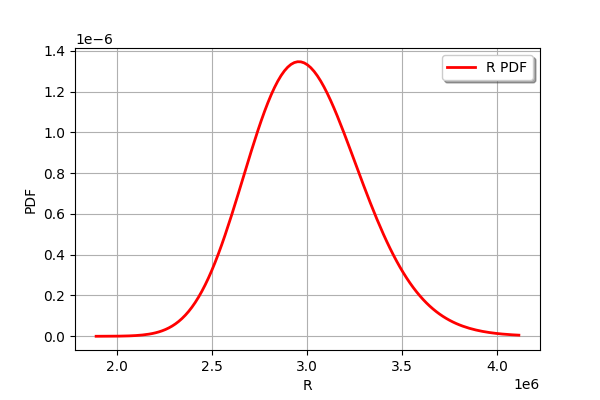

In [117]:
# Stochastic model definition

# Create a first marginal : LogNormal distribution 1D, parameterized by
# its mean and standard deviation
R_dist = ot.LogNormalMuSigma(3e6, 3e5, 0.).getDistribution()
R_dist.setName('Yield strength')
R_dist.setDescription('R')
print(R_dist)
# Graphical output of the PDF
R_dist.drawPDF()

LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0)


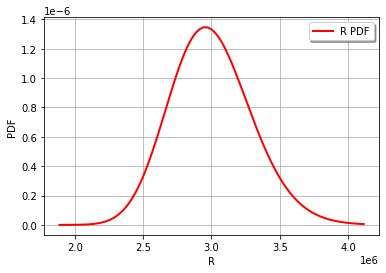

In [118]:
R_dist = sm.distribution_R
print(sm.distribution_R)
graph = R_dist.drawPDF()
view = viewer.View(graph)

Normal(mu = 750, sigma = 50)


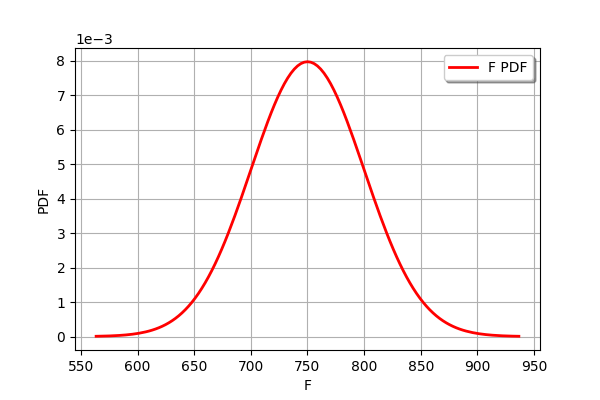

In [119]:
# Create a second marginal : Normal distribution 1D
F_dist = ot.Normal(750., 50.)
F_dist.setName('Traction_load')
F_dist.setDescription('F')
print(F_dist)
# Graphical output of the PDF
F_dist.drawPDF()

Normal(mu = 750, sigma = 50)


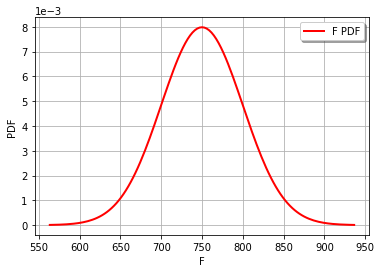

In [120]:
F_dist = sm.distribution_F
print(sm.distribution_F)
graph = F_dist.drawPDF()
view = viewer.View(graph)

In [121]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([R_dist, F_dist], aCopula)
myDistribution.setName('myDist')
print(myDistribution)
print(sm.distribution)

ComposedDistribution(LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0), Normal(mu = 750, sigma = 50), IndependentCopula(dimension = 2))
ComposedDistribution(LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0), Normal(mu = 750, sigma = 50), IndependentCopula(dimension = 2))


In [122]:
# We create a 'usual' RandomVector from the Distribution (X)
inputRandomVector = ot.RandomVector(myDistribution)

# We create a composite random vector (Z=G(X))
outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)

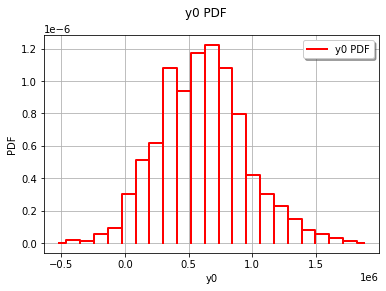

In [123]:
# Distribution of the output random vector
sampleSize = 1000
sampleG = outputRandomVector.getSample(sampleSize)
graph = ot.HistogramFactory().build(sampleG).drawPDF()
view = viewer.View(graph)

In [124]:
# We first create a ThresholdEvent based on the output RandomVector, the operator and the threshold.
myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 0.0)

In [125]:
# Exact computatiton of the probability 
# Prob(G<=0) = CDF_G(0)
D = 0.02
G = R_dist-F_dist/(D**2/4 * np.pi)
G.computeCDF(0.)

0.029198194624830504

# Estimate the probability with Monte-Carlo

In [126]:
maximumCoV = 0.01  # Coefficient of variation
maximumNumberOfBlocks = 1000000

In [127]:
experiment = ot.MonteCarloExperiment()

algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(maximumNumberOfBlocks)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(maximumCoV)

In [128]:
initialNumberOfCallMC = limitStateFunction.getEvaluationCallsNumber()

In [129]:
algoMC.run()

In [130]:
resultMC = algoMC.getResult()
probabilityMonteCarlo = resultMC.getProbabilityEstimate()
numberOfFunctionEvaluationsMonteCarlo = limitStateFunction.getEvaluationCallsNumber() - \
    initialNumberOfCallMC
print('Number of calls to the limit state =', numberOfFunctionEvaluationsMonteCarlo)
print('Pf = ', probabilityMonteCarlo)
print('CV =', resultMC.getCoefficientOfVariation())

Number of calls to the limit state = 327990
Pf =  0.029589316747461823
CV = 0.0099995398310019


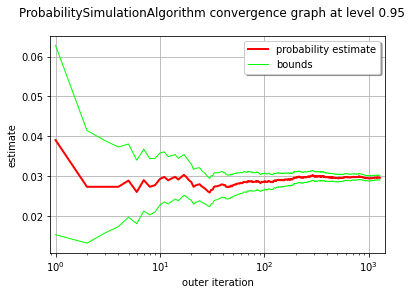

In [131]:
graph = algoMC.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
view = viewer.View(graph)

In [132]:
alpha = 0.05
pflen = result.getConfidenceLength(1-alpha)
print("%.2f%% confidence interval = [%f,%f]" % (
    (1-alpha)*100, probabilityMonteCarlo-pflen/2, probabilityMonteCarlo+pflen/2))

95.00% confidence interval = [0.029010,0.030168]


# Using FORM analysis

In [133]:
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
myCobyla.setMaximumEvaluationNumber(100)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

In [134]:
initialNumberOfCallFORM = limitStateFunction.getEvaluationCallsNumber()

In [135]:
algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

In [136]:
algoFORM.run()

In [137]:
resultFORM = algoFORM.getResult()
numberOfFunctionEvaluationsFORM = limitStateFunction.getEvaluationCallsNumber() - \
    initialNumberOfCallFORM
probabilityFORM = resultFORM.getEventProbability()
print('Number of calls to the limit state =', numberOfFunctionEvaluationsFORM)
print('Pf =', probabilityFORM)

Number of calls to the limit state = 98
Pf = 0.02998278558231473


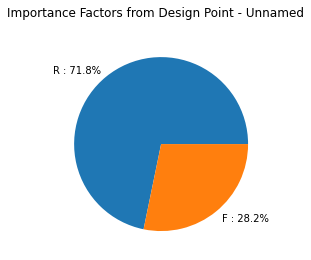

In [138]:
graph = resultFORM.drawImportanceFactors()
view = viewer.View(graph)

# Using Directional sampling

In [139]:
cv = 0.01
NbSim = 1000000

In [140]:
algoDS = ot.DirectionalSampling(myEvent)

algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)

In [141]:
initialNumberOfCallDS = limitStateFunction.getEvaluationCallsNumber()

In [142]:
algoDS.run()

In [143]:
resultDS = algoDS.getResult()
probabilityDirectionalSampling = resultDS.getProbabilityEstimate()
numberOfFunctionEvaluationsDirectionalSampling = limitStateFunction.getEvaluationCallsNumber() - \
    initialNumberOfCallDS
print('Number of calls to the limit state =',
      numberOfFunctionEvaluationsDirectionalSampling)
print('Pf = ', probabilityDirectionalSampling)
print('CV =', resultDS.getCoefficientOfVariation())

Number of calls to the limit state = 231890
Pf =  0.02880049746591155
CV = 0.009999774874889001


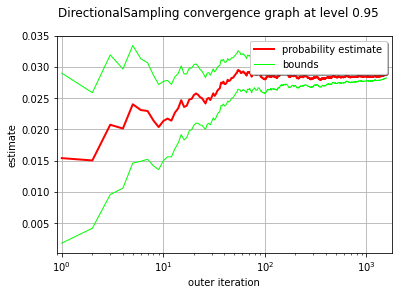

In [144]:
graph = algoDS.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
view = viewer.View(graph)

# Using importance sampling with FORM design point: IS-FORM

In [145]:
standardSpaceDesignPoint = resultFORM.getStandardSpaceDesignPoint()
standardSpaceDesignPoint

class=Point name=Standard Space Design Point dimension=2 values=[-1.59355,0.999463]

In [146]:
dimension = myDistribution.getDimension()
dimension

2

In [147]:
myImportance = ot.Normal(dimension)
myImportance.setMean(standardSpaceDesignPoint)
myImportance

class=Normal name=Normal dimension=2 mean=class=Point name=Standard Space Design Point dimension=2 values=[-1.59355,0.999463] sigma=class=Point name=Unnamed dimension=2 values=[1,1] correlationMatrix=class=CorrelationMatrix dimension=2 implementation=class=MatrixImplementation name=Unnamed rows=2 columns=2 values=[1,0,0,1]

In [148]:
experiment = ot.ImportanceSamplingExperiment(myImportance)

Create the standard event corresponding to the event. This transforms the original problem into the U-space, with Gaussian independent marginals.

In [149]:
standardEvent = ot.StandardEvent(myEvent)

We then create the simulation algorithm.

In [150]:
algoFORMIS = ot.ProbabilitySimulationAlgorithm(standardEvent, experiment)

algoFORMIS.setMaximumCoefficientOfVariation(cv)
algoFORMIS.setMaximumOuterSampling(40000)

In [151]:
initialNumberOfCallFORMIS = limitStateFunction.getEvaluationCallsNumber()

In [152]:
algoFORMIS.run()

In [153]:
resultFORMIS = algoFORMIS.getResult()
probabilityFORMIS = resultFORMIS.getProbabilityEstimate()
numberOfFunctionEvaluationsFORMIS = limitStateFunction.getEvaluationCallsNumber() - \
    initialNumberOfCallFORMIS
print('Number of calls to the limit state =',
      numberOfFunctionEvaluationsFORMIS)
print('Pf = ', probabilityFORMIS)
print('CV =', resultFORMIS.getCoefficientOfVariation())

Number of calls to the limit state = 22382
Pf =  0.029537534430021512
CV = 0.009999143195080261


## Conclusions

In [154]:
def computeLogRelativeError(exact, computed):
    logRelativeError = -np.log10(abs(exact - computed) / abs(exact))
    return logRelativeError

In [155]:
def printMethodSummary(name, computedProbability, numberOfFunctionEvaluations):
    print("---")
    print(name, ":")
    print('Number of calls to the limit state =', numberOfFunctionEvaluations)
    print('Pf = ', computedProbability)
    exactProbability = 0.02919819462483051
    logRelativeError = computeLogRelativeError(
        exactProbability, computedProbability)
    print("Number of correct digits=%.3f" % (logRelativeError))
    performance = logRelativeError/numberOfFunctionEvaluations
    print("Performance=%.2e (correct digits/evaluation)" % (performance))
    return

In [156]:
printMethodSummary("Monte-Carlo", probabilityMonteCarlo,
                   numberOfFunctionEvaluationsMonteCarlo)
printMethodSummary("FORM", probabilityFORM, numberOfFunctionEvaluationsFORM)
printMethodSummary("DirectionalSampling", probabilityDirectionalSampling,
                   numberOfFunctionEvaluationsDirectionalSampling)
printMethodSummary("IS-FORM", probabilityFORMIS,
                   numberOfFunctionEvaluationsFORMIS)

---
Monte-Carlo :
Number of calls to the limit state = 327990
Pf =  0.029589316747461823
Number of correct digits=1.873
Performance=5.71e-06 (correct digits/evaluation)
---
FORM :
Number of calls to the limit state = 98
Pf =  0.02998278558231473
Number of correct digits=1.571
Performance=1.60e-02 (correct digits/evaluation)
---
DirectionalSampling :
Number of calls to the limit state = 231890
Pf =  0.02880049746591155
Number of correct digits=1.866
Performance=8.05e-06 (correct digits/evaluation)
---
FORM-IS :
Number of calls to the limit state = 22382
Pf =  0.029537534430021512
Number of correct digits=1.935
Performance=8.64e-05 (correct digits/evaluation)


https://openturns.github.io/openturns/latest/auto_reliability_sensitivity/reliability/plot_axial_stressed_beam.html